In [80]:
from matplotlib.colors import ListedColormap
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import InputLayer, Flatten, Dense, Reshape, Input, BatchNormalization
from tensorflow.keras.models import Sequential, Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical

In [3]:
#inspiration taken from https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras/

faces = fetch_olivetti_faces()

X = faces.data
y = faces.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

In [4]:
def build_autoencoder(img_shape, code_size):
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape)))
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [5]:
def create_image_from_vector(img_vector, image_dimentions):
    return img_vector.reshape(image_dimentions, image_dimentions)


In [6]:
IMG_SHAPE = X.shape[1:]
code_size = 1024
encoder, decoder = build_autoencoder(IMG_SHAPE, code_size)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp, reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4096)]            0         
_________________________________________________________________
sequential (Sequential)      (None, 1024)              4195328   
_________________________________________________________________
sequential_1 (Sequential)    (None, 4096)              4198400   
Total params: 8,393,728
Trainable params: 8,393,728
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=200, validation_data=[X_test, X_test], verbose=0, shuffle=True)
print('Done')

Done


In [17]:
def plot_fitting_results(history):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

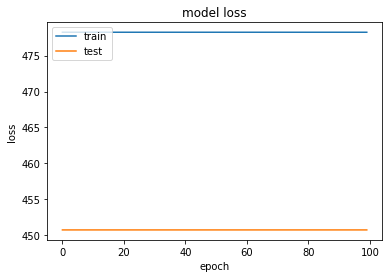

In [18]:
plot_fitting_results(history)


In [9]:
def visualize(img, encoder, decoder):
    """Draws original, encoded and decoded image"""
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.reshape(64,64))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//8, -1]))
    # plt.imshow(code.reshape(16,-1))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco.reshape(64,64))
    plt.show()


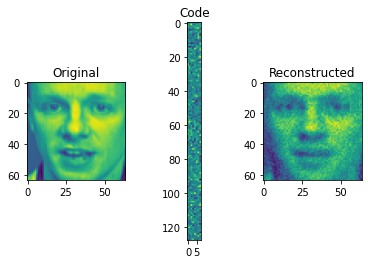

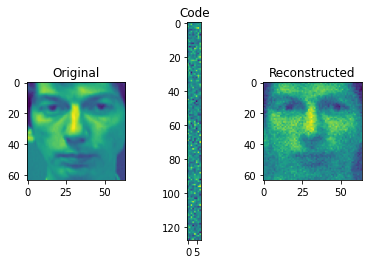

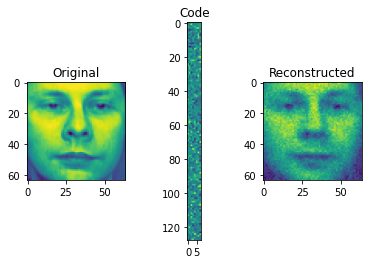

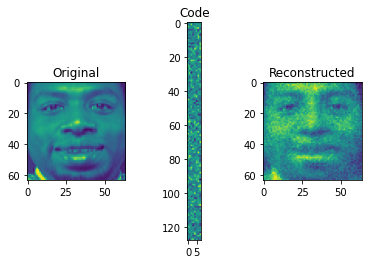

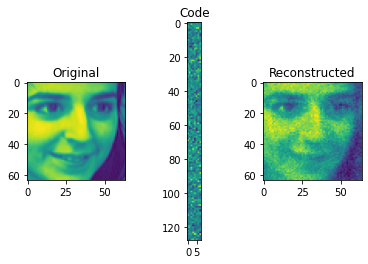

In [10]:
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [11]:
# image recognition based on autoencoder

encoded = encoder.predict(X_test)
decoded = decoder.predict(encoded)

(1, 5)


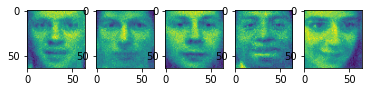

In [12]:
images_to_plot = 5
f, axarr = plt.subplots(1, images_to_plot, squeeze=False)
print(axarr.shape)
for i in range(images_to_plot):
    image = create_image_from_vector(decoded[i], 64)
    axarr[0, i].imshow(image)
plt.show()

In [127]:
encoded_X_train = encoder.predict(X_train)
encoded_X_test = encoder.predict(X_test)
# encoded_X_reshaped = encoded_X.reshape(360,code_size)
print(encoded_X_train.shape)

(360, 1024)


In [135]:
print((encoded_X_train[1]))

[ 0.03707108 -0.3595202   0.4537853  ...  0.26660317 -0.5133905
 -0.0159049 ]


In [187]:
model = Sequential([
    # BatchNormalization(input_shape=(code_size,)), #normalizing input data
                    Dense(units=code_size*2, activation='relu', input_shape=(code_size,)),
                    Dense(units=40, activation='relu'),
                    Dense(units=1, activation='relu', name='output_layer')])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()


Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 2048)              2099200   
_________________________________________________________________
dense_37 (Dense)             (None, 40)                81960     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 41        
Total params: 2,181,201
Trainable params: 2,181,201
Non-trainable params: 0
_________________________________________________________________


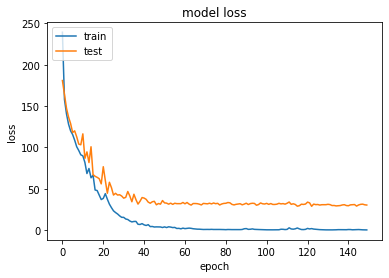

In [185]:
history = model.fit(x=encoded_X_train, y=y_train, epochs=150, batch_size=32, validation_data=(encoded_X_test, y_test), verbose=0)
plot_fitting_results(history)

In [207]:
def translate_categorical(categorical_array):
    print(categorical_array.shape)
    categories = categorical_array.shape[1]
    result = np.zeros(categories)
    ind = categorical_array[345]
    print(ind)
    for el in categorical_array:
        index = np.where(categorical_array[el]==1)
        result[el] = index
    return result


In [210]:
predictions_on_X_train = model.predict(encoded_X_train)
prediction_cat = to_categorical(predictions_on_X_train, num_classes=40)
print(prediction_cat.shape)
ind = 90
print(predictions_on_X_train[ind])
print(prediction_cat[ind])
print(X_train[ind], y_train[ind])
predictions_translate = translate_categorical(prediction_cat)

(360, 40)
[0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.49586776 0.4876033  0.62396693 ... 0.10330579 0.10743801 0.11157025] 31
(360, 40)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


IndexError: arrays used as indices must be of integer (or boolean) type

In [84]:
cmap = ListedColormap(['lightgrey', 'silver', 'ghostwhite', 'lavender', 'wheat'])
# Confusion matrix
def plot_confusion_matrix(predicted, expected, title):
    cm = confusion_matrix(predicted, expected)
    plt.figure()
    plt.matshow(cm, cmap=cmap)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(x=j, y=i, s=cm[i,j], va='center', ha='center')

    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [180]:
print(y_train.shape, prediction_cat.shape)
plot_confusion_matrix(y_train, prediction_cat, 'Train')

(360,) (360, 40)


ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets